# Introduction

In this project, we will train a CNN model on medical images to detect metastatic cancer. The Kaggle dataset is modified from the "PCam" dataset and includes `.tif` image files, which have been labeled `0` or `1`, corresponding to whether cancer is seen in each image. (Labels were provided by Kaggle for the training data only.)

In [1]:
# # Some nonsense to connect to kaggle and download the dataset.
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! rm kaggle.json

In [4]:
# ! kaggle competitions download -c histopathologic-cancer-detection

In [5]:
# ! unzip histopathologic-cancer-detection.zip -d data

In [319]:
import os
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matplotimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.data import Dataset

In [73]:
data_dir = Path('data')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
train_y = pd.read_csv(data_dir / 'train_labels.csv')

test_ids = pd.read_csv(data_dir / 'sample_submission.csv')['id']
# len(set(test_ids) - set((fn[:-4] for fn in os.listdir(test_dir))))  # 0 (same id's)

# Exploratory Data Analysis

Training labels consist of an `id` and binary label $\in \{0, 1\}$. The images have filenames corresponding to that `id` -- i.e., `<id>.tif`.

In [11]:
train_y.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Total images in training data: 220025
Number of images with label 1: 89117 (40.5%)
Number of images with label 0: 130908 (59.5%)




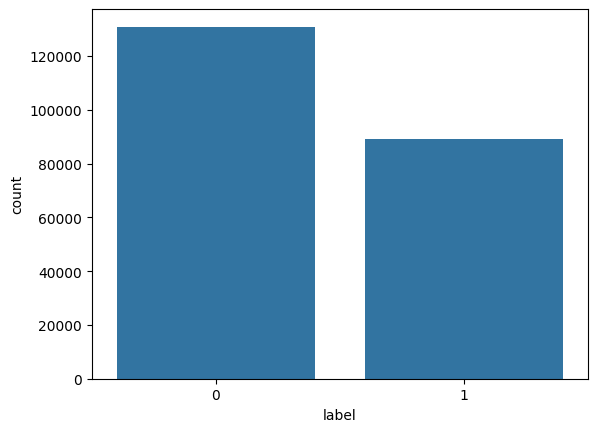

In [12]:
n = len(train_y)
print(f"Total images in training data: {n}")
ones = train_y['label'].sum()
print(f"Number of images with label 1: {ones} ({ones / n * 100:.1f}%)")
zeros = n - ones
print(f"Number of images with label 0: {zeros} ({zeros / n * 100:.1f}%)")
print('\n')
sns.countplot(x='label', data=train_y)
plt.show()

In [13]:
print("Total images in test data:", len(test_ids))
print(f"({((len(test_ids) / (len(test_ids) + len(train_y))) * 100):.1f}% test split)")

Total images in test data: 57458
(20.7% test split)


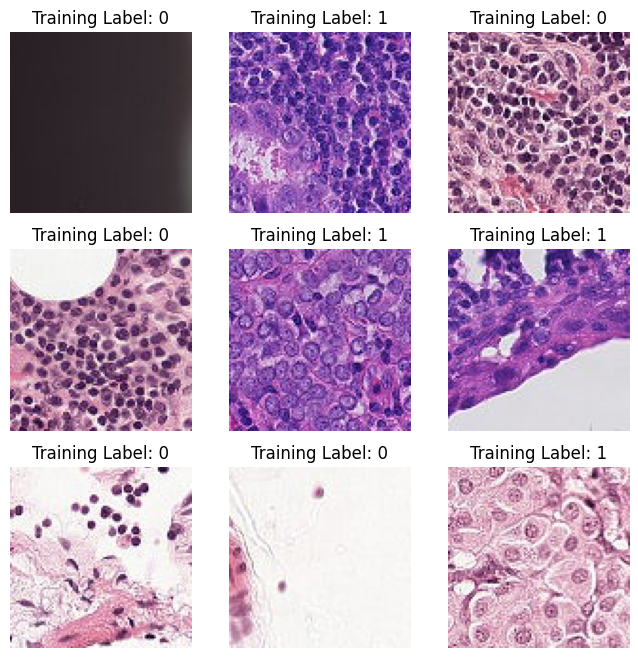

In [28]:
# Reference for visualizing images in a grid: https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
vis_sample = train_y.sample(9, random_state=42)
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for ax, (idx, row) in zip(axs, vis_sample.iterrows()):
    img_fp = train_dir / f"{row['id']}.tif"
    img = matplotimg.imread(img_fp)
    ax.imshow(img)
    ax.set_title(f"Training Label: {row['label']}")
    ax.axis('off')
plt.show()

Images are 96x96 pixels, with 3 color channels, which is larger than the 28x28 grayscale MNIST dataset but still *__much__* smaller than many datasets we might encounter.

In [29]:
img = load_img(train_dir / "f38a6374c348f90b587e046aac6079959adf3835.tif")
img_arr = img_to_array(img)
print("Dimensions of image:", img_arr.shape)
# Sanity check.
shapes = set()
for row in train_y.sample(1000, random_state=42).itertuples():
    img = load_img(train_dir / f"{row.id}.tif")
    img_arr = img_to_array(img)
    shapes.add(img_arr.shape)

for id in test_ids.sample(1000, random_state=42):
    img = load_img(test_dir / f"{id}.tif")
    img_arr = img_to_array(img)
    shapes.add(img_arr.shape)
print(
    "\n"
    "Sanity check...\n"
    "1000 sampled images from training data\n"
    "and 1000 sampled images from test data\n"
    "have same dimensions:  ",
    len(set(shapes)) == 1
)

Dimensions of image: (96, 96, 3)

Sanity check...
1000 sampled images from training data
and 1000 sampled images from test data
have same dimensions:   True


# CNN Architecture and Training

## Architecture

I'm just winging it here. So, for the feature extraction, we'll do 3 convolution layers with ReLU activation functions, and use max-pooling after each. For the classifier, we'll use a single hidden dense layer with a ReLU activation function, and the output layer with the sigmoid function (because this is a binary classification problem).

We'll use *__Adam__* optimizer to minimize *__binary cross-entropy__*, and measure *__accuracy__*.


## Training

At the suggestion of [some fine folks in the Slack channel for this class](https://cubouldermsds.slack.com/archives/C02TDLJ8F3P/p1711583401548269), we will train our model on a subset of the training data to mitigate the costs (time and resources), because our goals (as stated in the instructions for this assignment) are not to get an impressively high score on Kaggle.

Specifically, we will generate training and validation subsets using [stratified sampling](https://www.v7labs.com/blog/train-validation-test-set) to maintain the same distribution of labels in each subset.

In [18]:
def strat_sample(train_whole: pd.DataFrame, subset_size: int, train_valid_split: float = None, random_state=42):
    """
    Obtain a stratified sample of ``subset_size``.
    Specify ``train_valid_split=<float>`` to split the stratified sample
    into a training and validation subset.

    Returns a training and validation subset (and if ``train_valid_split`` is
    not specified, the validation subset will be ``None``).
    """
    pct_ones = train_whole[train_whole['label'] == 1]['id'].count() / len(train_whole)
    ones_target_count = int(subset_size * pct_ones)
    zeros_target_count = subset_size - ones_target_count
    ones_sample = train_whole[train_whole['label'] == 1].sample(ones_target_count, random_state=random_state)
    zeros_sample = train_whole[train_whole['label'] == 0].sample(zeros_target_count, random_state=random_state)
    if train_valid_split is None:
        train_sub = pd.concat([ones_sample, zeros_sample]).sample(frac=1).reset_index(drop=True)
        return train_sub, None

    train_sub_ones, valid_sub_ones = train_test_split(ones_sample, test_size=train_valid_split, random_state=random_state)
    train_sub_zeros, valid_sub_zeros = train_test_split(zeros_sample, test_size=train_valid_split, random_state=random_state)
    # df.sample(frac=1) shuffles the rows -- reference: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    train_sub = pd.concat([train_sub_ones, train_sub_zeros]).sample(frac=1).reset_index(drop=True)
    valid_sub = pd.concat([valid_sub_ones, valid_sub_zeros]).sample(frac=1).reset_index(drop=True)
    return train_sub, valid_sub


In [91]:
train_y['fp'] = train_y['id'].apply(lambda s: str(train_dir / f"{s}.tif"))
# train_y.head()

In [92]:
train_subset_size = 20000
train_sub, valid_sub = strat_sample(train_y, train_subset_size, train_valid_split=0.2)
n_valid_data = len(valid_sub)

In [241]:
def get_img(fp):
    """
    Load and preprocess the image at ``fp``.
    :param fp: Path to the image (in TF format).
    :return: The preprocessed image, as an array.
    """
    if not isinstance(fp, str):
        fp = fp.numpy().decode('utf-8')
    img = load_img(
        fp,
        target_size=(96, 96),
        color_mode='rgb',
    )
    img_arr = img_to_array(img)
    # img_arr = tf.ensure_shape(img_arr, (96, 96, 3))
    return img_arr

In [218]:
batch_size = 32

dataset_train = tf.data.Dataset.from_tensor_slices(
    (train_sub['fp'].to_list(), train_sub['label'].to_list()))
dataset_train = dataset_train.map(
    lambda fp, lbl: (tf.py_function(get_img, [fp], [tf.float32])[0], lbl))
dataset_train = dataset_train.map(lambda img, lbl: (tf.ensure_shape(img, (96, 96, 3)), lbl))
dataset_train = dataset_train.batch(batch_size)

dataset_valid = tf.data.Dataset.from_tensor_slices(
    (valid_sub['fp'].to_list(), valid_sub['label'].to_list()))
dataset_valid = dataset_valid.map(
    lambda fp, lbl: (tf.py_function(get_img, [fp], [tf.float32])[0], lbl))
dataset_valid = dataset_valid.map(lambda img, lbl: (tf.ensure_shape(img, (96, 96, 3)), lbl))
dataset_valid = dataset_valid.batch(batch_size)

### Build the Model

In [226]:
layers = [
    Input(shape=(96, 96, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
]
model = Sequential(layers)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [227]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 94, 94, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,009,345 (7.67 MB)

 Trainable params: 2,009,345 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [229]:
res = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_valid,
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 113ms/step - accuracy: 0.6888 - loss: 8.2591 - val_accuracy: 0.7890 - val_loss: 0.4699
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.7681 - loss: 0.5066 - val_accuracy: 0.7962 - val_loss: 0.4576
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - accuracy: 0.7878 - loss: 0.4719 - val_accuracy: 0.7920 - val_loss: 0.4758
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.7978 - loss: 0.4591 - val_accuracy: 0.8177 - val_loss: 0.4356
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.7972 - loss: 0.4489 - val_accuracy: 0.8150 - val_loss: 0.5099
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 95ms/step - accuracy: 0.7737 - loss: 0.5021 - val_accuracy: 0.7645 - val_loss: 0.4867
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.7977 - loss: 0.4479 - val_accuracy: 0.7903 - val_loss: 0.4693
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.8116 - loss: 0.4174 -

In [231]:
model.save("week3_cnn_model.keras")

## Prediction

We apply the model to the images in the test set, then extract labels by checking whether each `predicted_value > 0.5` (i.e., the threshold in the sigmoid function in the output layer).

In [264]:
test_batch_size = 32
test_fps = test_ids.apply(lambda s: str(test_dir / f"{s}.tif"))
dataset_test = tf.data.Dataset.from_tensor_slices(test_fps.to_list())
dataset_test = dataset_test.map(
    lambda fp: (tf.py_function(get_img, [fp], [tf.float32])[0])
)
dataset_test = dataset_test.map(lambda img: (tf.ensure_shape(img, (96, 96, 3))))
dataset_test = dataset_test.batch(test_batch_size)

In [265]:
pred = model.predict(dataset_test)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 154s 85ms/step


In [273]:
pred_test_labels = (pred > 0.5).astype(int)

In [282]:
test_y_final = pd.DataFrame(data={'id': test_ids, 'label': pred_test_labels.reshape(-1)})
test_y_final.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [283]:
test_y_final.to_csv('week3_cnn_submission.csv', index=False)

## Results

When submitted to Kaggle:
* Public score: 0.6443
* Private score: 0.7107

# Exploring the Callback History

In [310]:
def plot_history(history: dict):
    train_loss = history['loss']
    valid_loss = history['val_loss']
    train_acc = history['accuracy']
    valid_acc = history['val_accuracy']

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs = axs.flatten()
    loss_ax = axs[0]
    loss_ax.plot(train_loss, label='Training Loss')
    loss_ax.plot(valid_loss, label='Validation Loss')
    loss_ax.set_xlabel('Epoch')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xticks(range(len(train_loss) + 1))
    loss_ax.legend()

    acc_ax = axs[1]
    acc_ax.plot(train_acc, label='Training Accuracy')
    acc_ax.plot(valid_acc, label='Validation Accuracy')
    acc_ax.set_xlabel('Epoch')
    acc_ax.set_ylabel('Accuracy')
    acc_ax.set_xticks(range(len(train_loss) + 1))
    acc_ax.legend()
    plt.show()

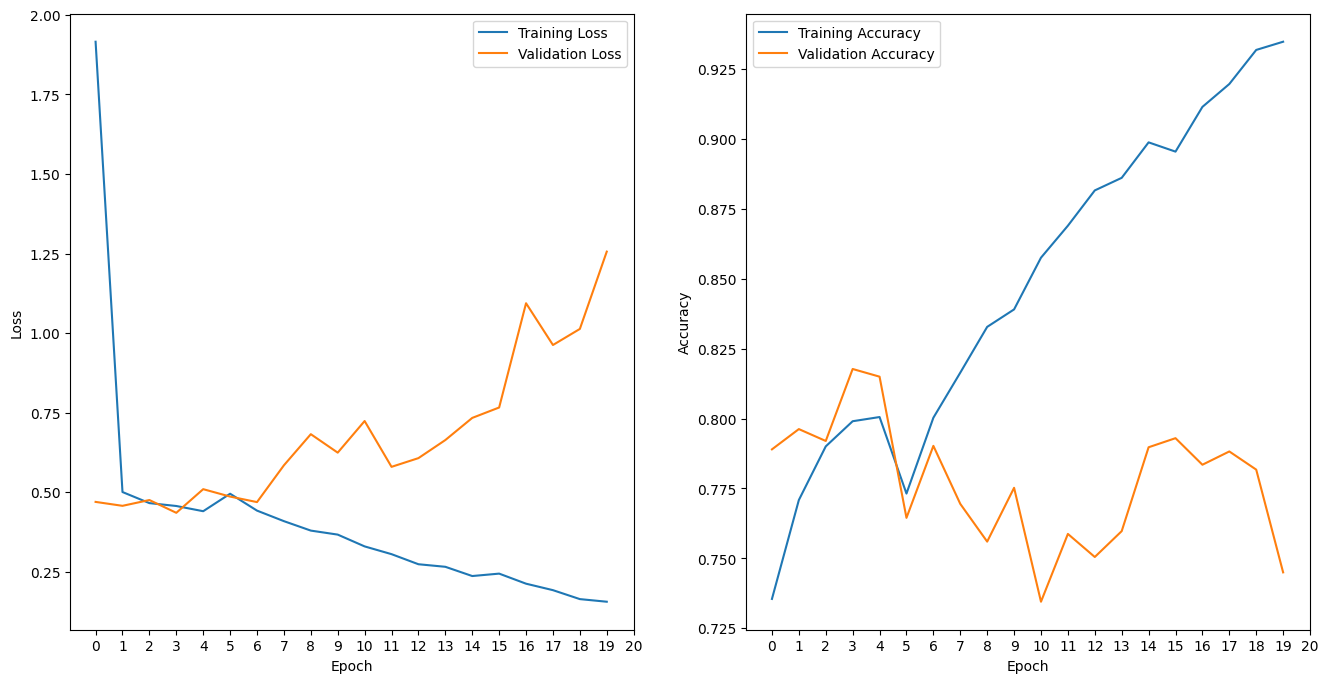

In [311]:
plot_history(res.history)

## Retrain with Fewer Epochs

Since we see diverging accuracy and loss after a while, let's retrain an identical model on only 5 epochs.

In [318]:
layers2 = [
    Input(shape=(96, 96, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
]
model2 = Sequential(layers2)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
res2 = model2.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_valid,
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.6320 - loss: 7.3592 - val_accuracy: 0.7680 - val_loss: 0.4883
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.7717 - loss: 0.4930 - val_accuracy: 0.8043 - val_loss: 0.4608
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.7822 - loss: 0.4720 - val_accuracy: 0.7853 - val_loss: 0.4702
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.7848 - loss: 0.4700 - val_accuracy: 0.7993 - val_loss: 0.4494
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.7932 - loss: 0.4546 - val_accuracy: 0.7945 - val_loss: 0.4562


In [323]:
model2.save('week3_cnn_model2_5epochs.keras')

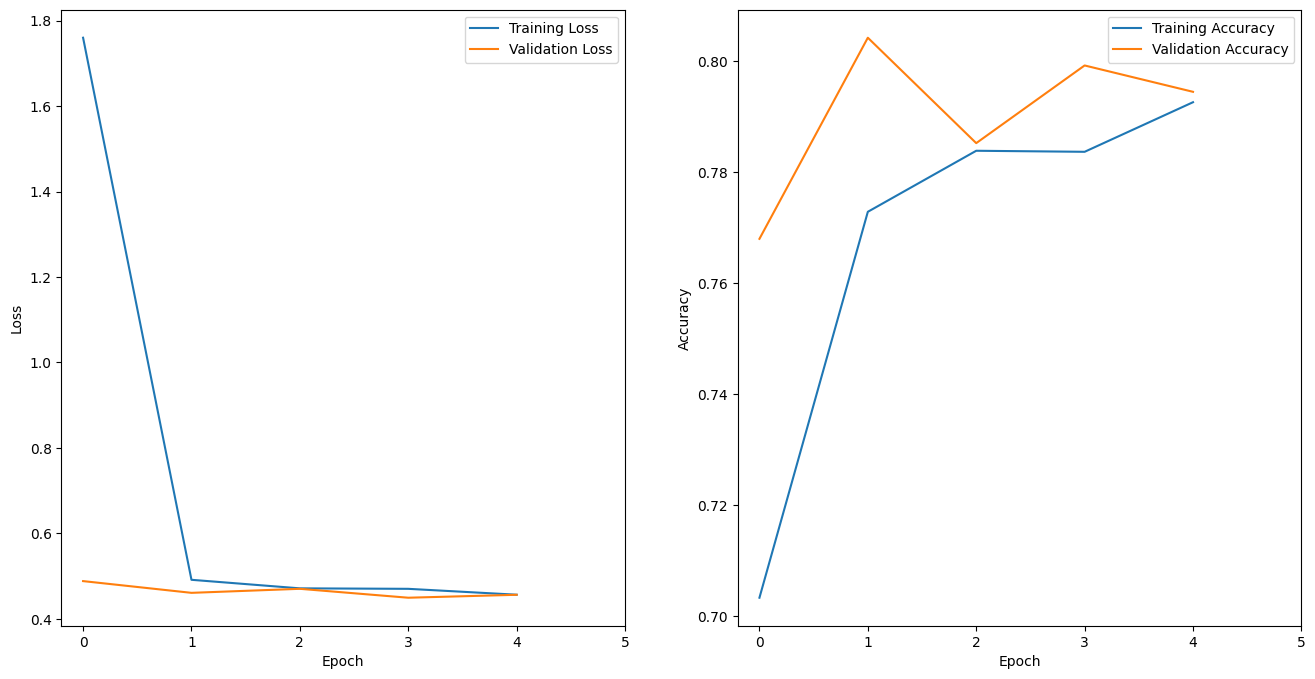

In [320]:
plot_history(res2.history)

In [321]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,028,037 (23.00 MB)

 Trainable params: 2,009,345 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,018,692 (15.33 MB)

In [322]:
pred2 = model2.predict(dataset_test)
pred2_test_labels = (pred2 > 0.5).astype(int)
test_y_final2 = pd.DataFrame(data={'id': test_ids, 'label': pred2_test_labels.reshape(-1)})
test_y_final2.head()
test_y_final2.to_csv('week3_cnn_submission2.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step


## Results (when trained with only 5 Epochs)

When submitted to Kaggle:
* Public score: 0.7111
* Private score: 0.7903

# Conclusions

The architecture we used for our model quickly overfit the data after only 5 epochs. Retraining an equivalent model on 5 epochs resulted in much better test accuracy.

# Citations

* https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
* https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
* https://cubouldermsds.slack.com/archives/C02TDLJ8F3P/p1711583401548269
* https://www.v7labs.com/blog/train-validation-test-set
* Lots of help with bugfixes from the built-in AI in Google Colab.